## Tennessee Surface Water Dynamics Analysis (2010-2020) in Earth Engine

#### Objectives: 
To display water occurence.

To extract surface water extent.

To calculate surface water areas.

To show temporal trend.


#### Data: 
JRC Global Surface Water Mapping : ee.Image(JRC/GSW1_4/GlobalSurfaceWater)

NAIP: National Agriculture Imagery : ee.ImageCollection("USDA/NAIP/DOQQ")

In [1]:
# To Install/import geemap package uncomment the folllowing:

# import subprocess

# try:
#     import geemap
# except ImportError:
#     print('geemap package not installed. Installing ...')
#     subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

In [2]:
# Import and initialize Earth Engine

import geemap
import ee
ee.Initialize()

In [3]:
# Create interactive map and define region of interest (ROI)

Map = geemap.Map()
roi = ee.FeatureCollection('TIGER/2018/States').filter(
    ee.Filter.eq('NAME', 'Tennessee')
)
# Map.addLayer(roi, {}, "TN")
# Map.centerObject(roi, 8)

In [4]:
dataset = ee.Image('JRC/GSW1_4/GlobalSurfaceWater')
dataset.bandNames()

In [5]:
Map.add_basemap('HYBRID')

In [6]:
#To display water occurence
# Select occurence band from image, 
#set visualization paramters, display image and center map to region of interest and add colorbar.

image = dataset.select(['occurrence'])
vis_params = {'min': 0.0, 'max': 100.0, 'palette': ['ffffff', 'ffbbbb', '0000ff']}
Map.addLayer(image, vis_params, 'Occurrence')
Map.addLayer(roi, {}, 'ROI', True, 0.5)
Map.centerObject(roi, 7)
Map.add_colorbar(vis_params, label='Water occurrence (%)', layer_name='Occurrence')
Map

Map(center=[35.8579904338385, -86.35074162079951], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
# Create NAIP timeseries

images = geemap.naip_timeseries(roi, start_year=2010, end_year=2020, RGBN=True)

In [8]:
first = images.first()

vis_params = {'bands': ['N', 'R', 'G'], 'min': 0, 'max': 250.0}

Map.addLayer(first, vis_params, 'First image')

In [9]:
first.bandNames()

In [10]:
# Calculate Normalized Difference Water Index (NDWI)
# NDWI = (Green − NIR)/(Green + NIR)


ndwi_images = images.map(
    lambda img: img.normalizedDifference(['G', 'N']).rename('ndwi')
)

ndwi_palette = [
    '#ece7f2',
    '#d0d1e6',
    '#a6bddb',
    '#74a9cf',
    '#3690c0',
    '#0570b0',
    '#045a8d',
    '#023858',
]

first_ndwi = ndwi_images.first()

Map.addLayer(first_ndwi, {'palette': ndwi_palette}, 'First NDWI')

In [11]:
# Extract surface water extent

water_images = ndwi_images.map(lambda img: img.gt(0).selfMask())

first_water = water_images.first()

Map.addLayer(first_water, {'palette': ['blue']}, 'First Water')

In [12]:
# Calculate surface water areas

def cal_area(img):
    pixel_area = img.multiply(ee.Image.pixelArea()).divide(1e6)
    img_area = pixel_area.reduceRegion(
        **{
            'geometry': roi.geometry(),
            'reducer': ee.Reducer.sum(),
            'scale': 1000,
            'maxPixels': 1e12,
        }
    )
    return img.set({'water_area': img_area})

In [13]:
water_areas = water_images.map(cal_area)

In [14]:
water_stats = water_areas.aggregate_array('water_area').getInfo()
water_stats

[{'ndwi': 2917.2196074627395},
 {'ndwi': 25.68676366740197},
 {'ndwi': 17469.931352386062},
 {'ndwi': 571.0674359112749},
 {'ndwi': 28642.31925181851},
 {'ndwi': 408.8281269561268},
 {'ndwi': 8971.185139908186},
 {'ndwi': 383.1028855995093},
 {'ndwi': 15144.590253869423},
 {'ndwi': 545.9140410071063},
 {'ndwi': 683.9380473553939}]

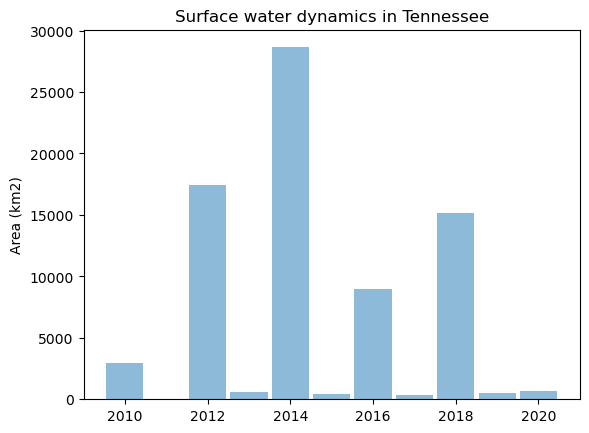

In [15]:
#Plot temporal trend

import matplotlib.pyplot as plt

x = list(range(2010, 2021))
y = [item.get('ndwi') for item in water_stats]

plt.bar(x, y, width=0.9, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
plt.ylabel('Area (km2)')
plt.title('Surface water dynamics in Tennessee 2010-2020')

plt.show()

In [16]:
Map.addLayerControl()
Map

Map(center=[35.8579904338385, -86.35074162079951], controls=(WidgetControl(options=['position', 'transparent_b…